In [24]:
from collections import defaultdict
from pyquil.api import SyncConnection as CloudSyncConnection
from referenceqvm.api import SyncConnection, gate_matrix
import numpy as np
from pyquil.quil import Program, Gate
from pyquil.quilbase import unpack_qubit
from pyquil.gates import H, CZ
from itertools import product as cartesian_product
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Circuits for assignment probability measurements and tomography

In [2]:
from grove.benchmarking.utils import (
    POVM_PI_BASIS, TOMOGRAPHY_GATES, TOMOGRAPHY_DEFCIRCUITS,
    make_diagonal_povm, sample_bad_readout, sample_outcomes, basis_state_preps, 
    make_histogram, estimate_assignment_probs, quil_to_operator
)
from grove.benchmarking.tomography import (StateTomography, ProcessTomography, 
                                           DEFAULT_STATE_TOMO_SETTINGS, DEFAULT_PROCESS_TOMO_SETTINGS,
                                           default_rotations, state_tomography_programs, process_tomography_programs)

# Estimating bitstring probabilities via histograms

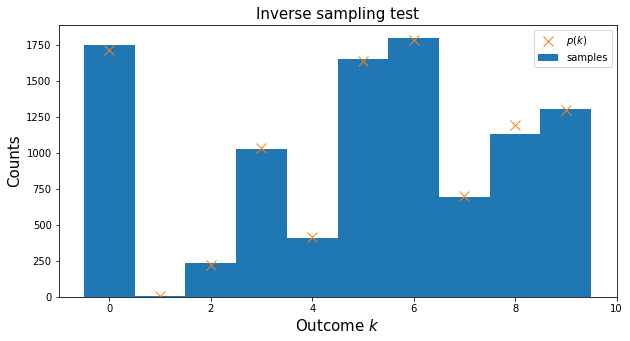

In [3]:
n = 10
N = 10000

probs = np.random.rand(n)
probs /= probs.sum()

samples = sample_outcomes(probs, N)
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=np.arange(n+1)-.5, label="samples")
plt.plot(probs * N, "x", ms=10, label="$p(k)$")
plt.title("Inverse sampling test", size=15)
plt.ylabel("Counts", size=15)
plt.xlabel("Outcome $k$", size=15)
plt.legend(loc="best")


# Simulate bad readout and estimate confusion matrix 

In [4]:
custom_gateset = gate_matrix.copy()
custom_gateset.update({k: v.data.toarray() for k, v in TOMOGRAPHY_GATES.items()})
cxn = SyncConnection(gate_set=custom_gateset)

In [5]:
BAD_1Q_READOUT = np.array([[.9, .15],
                           [.1, .85]])
estimate_assignment_probs([0], BAD_1Q_READOUT, 2000, cxn)

array([[ 0.8935,  0.1495],
       [ 0.1065,  0.8505]])

# State tomography

## Single qubit

/Users/nikolas/.virtualenvs/willowdev/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


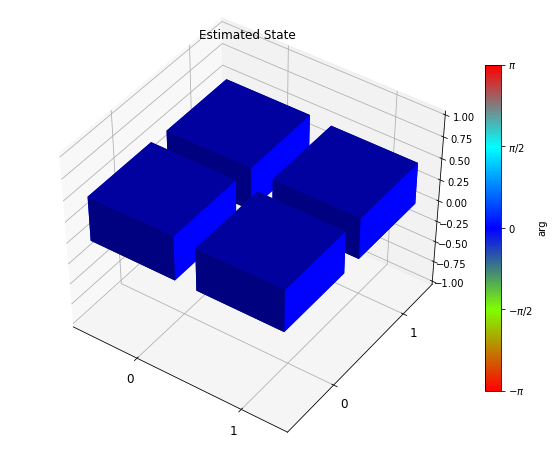

In [6]:
prog = Program(Gate("Y-HALF", (), [unpack_qubit(0)]))
nq = 1
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0], BAD_1Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_1Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

## Two qubit GHZ

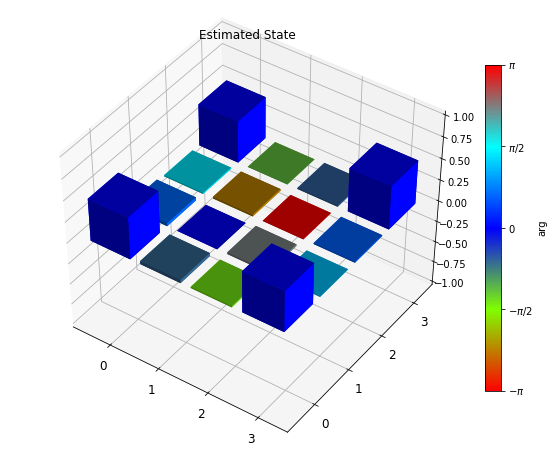

In [16]:
BAD_2Q_READOUT = np.kron(BAD_1Q_READOUT, BAD_1Q_READOUT)

prog = Program([H(0), 
                H(1),
                CZ(0, 1),
                H(1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0, 1], BAD_2Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

## N qubit GHZ

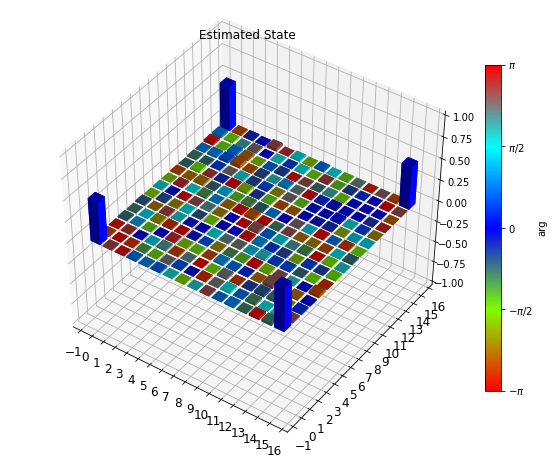

In [8]:
N = 4

BAD_NQ_READOUT = reduce(np.kron, [BAD_1Q_READOUT] * (N-1), BAD_1Q_READOUT)

prog = Program([H(0)] + [CNOT(j, j+1) for j in range(N-1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs(range(N), BAD_NQ_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_NQ_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

# Process tomography

## Single qubit

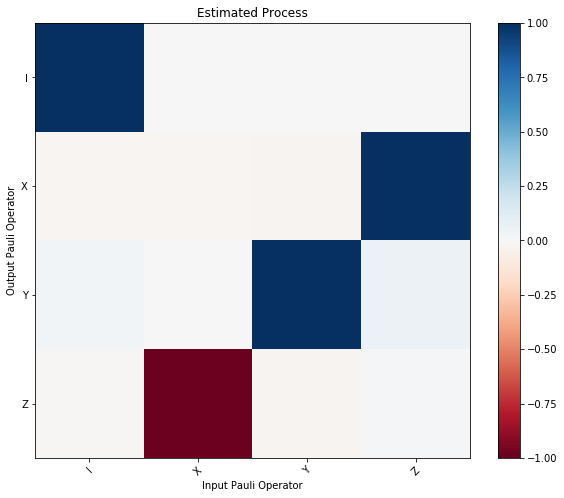

In [9]:
prog = Program(Gate("Y-HALF", (), [unpack_qubit(0)]))
nq = 1
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0], BAD_1Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_1Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms, povm, channel_ops, channel_ops, DEFAULT_PROCESS_TOMO_SETTINGS)
process_tomo.plot();

## CZ process tomography

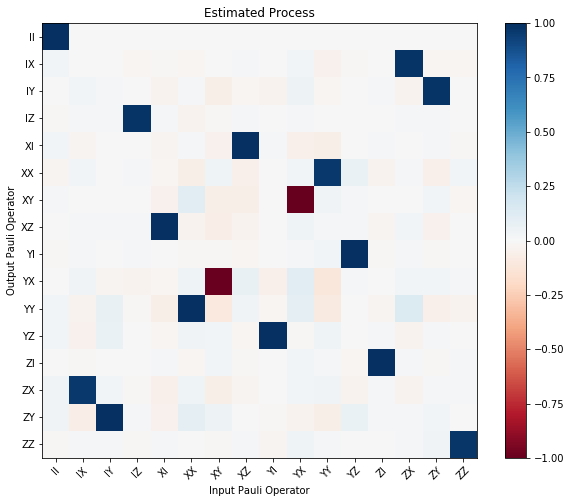

In [21]:
BAD_2Q_READOUT = np.kron(BAD_1Q_READOUT, BAD_1Q_READOUT)

prog = Program([CZ(0, 1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0, 1], BAD_2Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms.reshape((len(tomo_channels), len(tomo_channels), d)), povm, channel_ops, channel_ops, DEFAULT_PROCESS_TOMO_SETTINGS)
process_tomo.plot();

In [19]:
prog = Program([
                CZ(0, 1),
                ])

nq = len(prog.extract_qubits())
d = 2 ** nq

tomo_channels = list(default_rotations(*range(nq)))

tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = BAD_2Q_READOUT

histograms = np.zeros((len(tomo_seq), d))

for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)

histograms = histograms.reshape((len(tomo_channels), len(tomo_channels), d))

povm = make_diagonal_povm(POVM_PI_BASIS ** nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms, povm, channel_ops, channel_ops,
                                               DEFAULT_PROCESS_TOMO_SETTINGS)

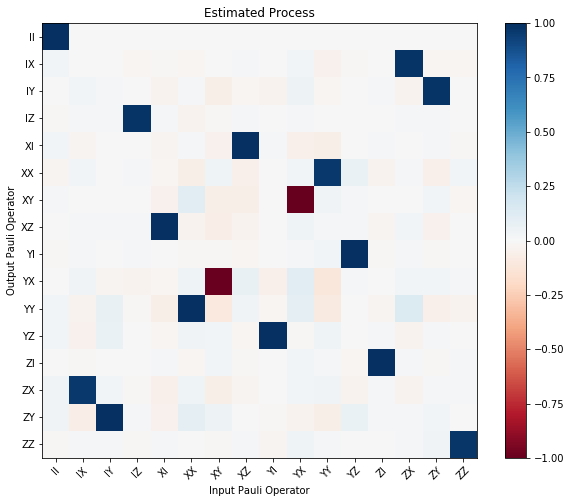

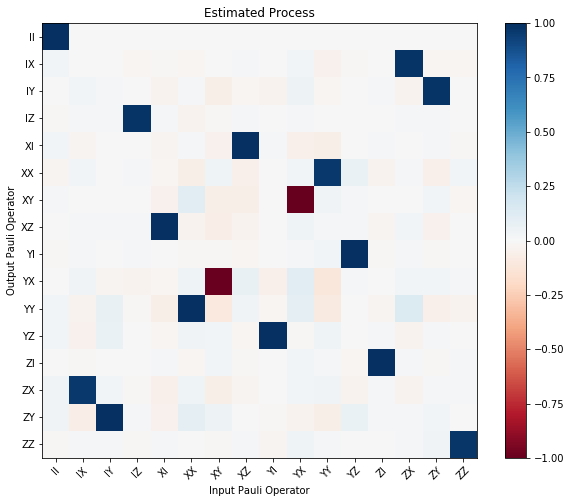

In [23]:
process_tomo.plot()

In [26]:
prog = Program([H(0),
                H(1),
                CZ(0, 1),
                H(1)
                ])

In [27]:
cxn_cloud = CloudSyncConnection()

In [29]:
cxn_cloud.run_and_measure(prog, [0, 1, 2], 1000)

[[1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [1, 1, 0],
 [1,

In [ ]:
cxn.run_and_measure